In [139]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor ,RandomForestRegressor ,GradientBoostingRegressor
from xgboost import XGBRegressor 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge,Lasso
import warnings
warnings.filterwarnings('ignore')
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns',None)
os.chdir('C:/Users/lenovo/Desktop/Omkar/Hackathon/Updated Hackathon')

In [111]:
def detect_outliers(dataframe):
    cols = list(dataframe)
    outliers = pd.DataFrame(columns=['Feature','Number of Outliers'])
    
    for column in cols:
        if column in dataframe.select_dtypes(include=np.number).columns:
            # first quartile (Q1)
            q1 = dataframe[column].quantile(0.25) 
            
            # third quartile (Q3)
            q3 = dataframe[column].quantile(0.75)
            
            # IQR
            iqr = q3 - q1
            
            fence_low = q1 - (1.5*iqr)
            fence_high = q3 + (1.5*iqr)
            outliers = outliers.append({'Feature':column,'Number of Outliers':dataframe.loc[(dataframe[column] < fence_low) | (dataframe[column] > fence_high)].shape[0]},ignore_index=True)
    return outliers
# Function to treat outliers 
def treat_outliers(dataframe):
    cols = list(dataframe)
    for col in cols:
        if col in dataframe.select_dtypes(include=np.number).columns:
            dataframe[col] = winsorize(dataframe[col], limits=[0.05, 0.1],inclusive=(True, True))
    
    return dataframe
def rmsle(actual_column, predicted_column):
    sum=0.0
    for x,y in zip(actual_column,predicted_column):
        if x<0 or y<0: #check for negative values. 
            continue
        p = np.log(y+1)
        r = np.log(x+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted_column))**0.5

In [141]:
df_details = pd.read_excel('Data_Dictionary.xlsx')
df_details

,Variable,Description
0,ID,Unique ID for every Customer
1,account_type,Account Type – current or saving
2,gender,Gender of customer
3,age,Age of customer
4,region_code,Code assigned to region of residence (has order)
5,cc_cons_apr,Credit card spend in April
6,dc_cons_apr,Debit card spend in April
7,cc_cons_may,Credit card spend in May
8,dc_cons_may,Debit card spend in May
9,cc_cons_jun,Credit card spend in June


In [146]:
df = pd.read_csv('Train.csv')
df_test = pd.read_csv('Test.csv')
df.drop(['personal_loan_active','personal_loan_closed','vehicle_loan_active','vehicle_loan_closed','loan_enq'],axis = 1,inplace= True)
df_test.drop(['personal_loan_active','personal_loan_closed','vehicle_loan_active','vehicle_loan_closed','loan_enq'],axis = 1,inplace= True)
df['cc_cons_avg'] = (df['cc_cons_apr'] + df['cc_cons_may'] + df['cc_cons_jun'])/3
df_test['cc_cons_avg'] = (df_test['cc_cons_apr'] + df_test['cc_cons_may'] + df_test['cc_cons_jun'])/3
df.set_index('ID',inplace= True)
df_test.set_index('ID',inplace= True)
df = treat_outliers(df)
df_test = treat_outliers(df_test)
outliers_df =detect_outliers(df)
outliers_test = detect_outliers(df_test)
for col in df.select_dtypes(include ='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    df_test[col] = le.transform(df_test[col])

In [147]:
outliers_df

,Feature,Number of Outliers
0,age,0
1,region_code,0
2,cc_cons_apr,0
3,dc_cons_apr,0
4,cc_cons_may,0
5,dc_cons_may,0
6,cc_cons_jun,0
7,dc_cons_jun,0
8,cc_count_apr,0
9,cc_count_may,0


In [113]:
df['investment_1'] =  np.log(df['investment_1'] )
df['investment_3'] = np.sqrt(df['investment_3'])
df['credit_count_may'] = np.log(df['credit_count_may'])
df['credit_count_jun'] = np.sqrt(df['credit_count_jun'])
#df['cc_cons'] = np.(df['cc_cons'])
df_test['investment_1'] =  np.log(df_test['investment_1'] )
df_test['investment_3'] = np.sqrt(df_test['investment_3'])
df_test['credit_count_may'] = np.log(df_test['credit_count_may'])
df_test['credit_count_jun'] = np.sqrt(df_test['credit_count_jun'])

0.05     1291.0
0.80    84829.2
Name: cc_cons, dtype: float64


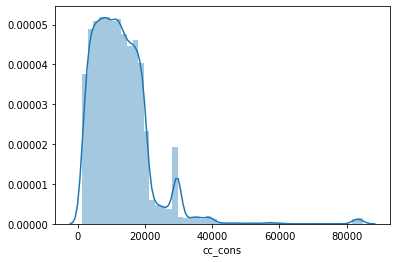

In [114]:
lower_bound =0.05
upper_bound =0.8
result = df['cc_cons'].quantile([lower_bound,upper_bound])
print(result)
true_index = (result.loc[lower_bound] < df.cc_cons.values) & (df.cc_cons.values < result.loc[upper_bound])
false_index =~true_index
for i in df.cc_cons[false_index].index:
    df.cc_cons.loc[i] = df.cc_cons_avg[i]
sns.distplot(df['cc_cons'])

In [115]:
X=df.drop('cc_cons',axis=1)
y=df.cc_cons
target_col ='cc_cons'

In [116]:
train_x,test_x,train_y,test_y = train_test_split(X,y,test_size = 0.3, random_state = 42)

In [117]:
target_scaler = MinMaxScaler()
feature_scaler = MinMaxScaler()
feature_scaler.fit(train_x)
target_scaler.fit(train_y.values.reshape(-1,1))
train_x_scaled =feature_scaler.transform(train_x)
test_x_scaled = feature_scaler.transform(test_x)
train_y_scaled = target_scaler.transform(train_y.values.reshape(-1,1))
test_y_scaled = target_scaler.transform(test_y.values.reshape(-1,1))
train_x_scaled = pd.DataFrame(train_x_scaled,columns = X.columns,index =train_x.index)
test_x_scaled = pd.DataFrame(test_x_scaled,columns = X.columns,index =test_x.index)
df_test_scaled = feature_scaler.transform(df_test)
df_test_scaled = pd.DataFrame(df_test_scaled,columns = df_test.columns,index =df_test.index)

In [118]:
df_test_scaled.head()

,account_type,gender,age,region_code,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,cc_cons_avg
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17591,0.0,1.0,0.250000,0.514196,0.039140,0.050613,0.144598,0.016946,0.317167,0.975626,0.037975,0.098765,0.012195,0.938776,1.000000,0.064103,0.197980,-0.023048,0.780348,0.049166,0.030267,0.168075,0.252903,0.164557,1.000000,0.164003,0.136256,0.214706,0.844957,0.2000,0.042531,0.163867,0.176967,0.051251,0.099010,0.245512,0.049518,0.095689
13541,0.0,1.0,0.138889,0.228707,0.708472,0.069994,0.017783,0.131035,0.385895,0.036659,0.025316,0.098765,0.012195,1.000000,0.860465,0.384615,0.064646,0.754910,0.974721,0.017243,0.993796,0.202382,0.100426,0.493671,0.142857,-0.003446,0.071444,0.747196,1.000000,0.4500,0.117033,0.050192,0.081194,0.166938,0.366337,0.105952,0.828202,0.401685
13431,0.0,1.0,0.694444,0.118297,0.119374,0.321896,0.046887,0.022659,-0.000763,0.242078,0.075949,0.345679,0.024390,0.469388,0.604651,0.012821,0.046463,0.676357,0.974721,0.630102,0.472732,0.432982,0.200310,0.481013,0.171429,0.053011,0.979763,0.206690,0.993744,0.3875,0.317622,0.177740,0.191758,0.132524,0.069307,0.116125,0.123518,-0.010455
8687,0.0,1.0,0.138889,0.190852,0.021796,0.988392,0.956439,0.000000,0.130759,0.984786,0.000000,1.000000,0.829268,0.081633,0.000000,0.128205,0.995960,0.461669,0.974721,0.159297,0.628217,0.256044,0.244953,0.544304,0.028571,0.982644,0.719596,0.253153,0.292091,0.0125,0.951739,0.606657,0.686566,0.510898,-0.009901,0.716792,0.007228,0.390272
14727,0.0,1.0,0.944444,0.403785,0.051052,0.174764,0.059999,0.146089,0.096926,0.305877,0.012658,0.098765,0.536585,0.081633,0.558140,0.000000,0.252525,0.992567,0.002069,1.000000,0.407211,0.028546,0.054713,0.101266,0.028571,0.047714,0.989790,0.119513,1.000000,0.8875,0.230267,0.082982,0.243015,0.166938,0.326733,0.412169,0.133198,-0.010166


In [119]:
test_y_scaled

array([[0.12316515],
       [0.20175523],
       [0.11913029],
       ...,
       [0.02677239],
       [0.06318096],
       [0.15732382]])

In [124]:
list1 =['account_type', 'gender', 'age', 'region_code', 'cc_cons_apr', 'cc_cons_may', 'dc_cons_may', 'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr', 'cc_count_may', 'cc_count_jun', 'dc_count_apr', 'dc_count_may', 'dc_count_jun', 'investment_3', 'investment_4', 'credit_amount_apr', 'debit_count_apr', 'credit_count_apr', 'max_credit_amount_apr', 'debit_amount_may', 'credit_count_may', 'debit_count_may', 'max_credit_amount_may', 'credit_amount_jun', 'credit_count_jun', 'debit_count_jun', 'max_credit_amount_jun', 'emi_active']

In [125]:
model = LinearRegression()
model.fit(train_x_scaled.loc[:,List1], train_y_scaled)

yhat_train = model.predict(train_x_scaled.loc[:,List1])
print('RMSLE Value Train is ',rmsle(train_y_scaled, yhat_train))

yhat = model.predict(test_x_scaled.loc[:,List1])
print('RMSLE Value is ',rmsle(test_y_scaled, yhat))
yhat_transform = target_scaler.inverse_transform(yhat)
print('RMSLE Value is ',rmsle(test_y, yhat_transform))
df_test_pred = model.predict(df_test_scaled.loc[:,List1])
df_hat_transform = target_scaler.inverse_transform(df_test_pred)
sample_submission11 =pd.DataFrame(df_hat_transform,columns = ['cc_cons'],index= df_test.index)
sample_submission11.to_csv('submission11.csv')

RMSLE Value Train is  [0.08589522]
RMSLE Value is  [0.08547965]
RMSLE Value is  [0.74499645]


In [128]:
model = LinearRegression()
rfe = RFE(model,25)

X_train_rfe = rfe.fit_transform(train_x,train_y)
X_test_rfe = rfe.transform(test_x)
df_test_rfe  = rfe.transform(df_tes t)
model.fit(X_train_rfe,y_train)
y_rfe = model.predict(X_test_rfe)
df_test_rfe_pred = model.predict(df_test_rfe)

X_train_rfe_scaled = rfe.fit_transform(train_x_scaled,train_y_scaled)
X_test_rfe_scaled =  rfe.transform(test_x_scaled)
df_test_rfe_scaled =rfe.transform(df_test_scaled)
model.fit(X_train_rfe_scaled,train_y_scaled)
y_rfe_Scaled = model.predict(X_test_rfe_scaled)
df_test_rfe_scaled_pred = model.predict(df_test_rfe_scaled)
df_test_rfe_scaled_pred_transform = target_scaler.inverse_transform(df_test_rfe_scaled_pred.reshape(-1,1))


print('RMSLE Value is ',rmsle(test_y, y_rfe))
print('RMSLE Value is ',rmsle(test_y_scaled, y_rfe_Scaled))
y_rfe_transform = target_scaler.inverse_transform(y_rfe_Scaled.reshape(-1,1))
print('RMSLE Value is ',rmsle(test_y, y_rfe_transform))

sample_submission12 =pd.DataFrame(df_test_rfe_pred,columns = ['cc_cons'],index= df_test.index)
sample_submission12.to_csv('submission12.csv')
sample_submission13 =pd.DataFrame(df_test_rfe_scaled_pred_transform,columns = ['cc_cons'],index= df_test.index)
sample_submission13.to_csv('submission13.csv')

RMSLE Value is  0.7227782417477965
RMSLE Value is  [0.08288097]
RMSLE Value is  [0.7233032]


In [129]:
model = DecisionTreeRegressor(max_depth=3,random_state=17)
model.fit(train_x_scaled, train_y_scaled)
y_dt = model.predict(test_x_scaled)
y_dt_transform = target_scaler.inverse_transform(y_dt.reshape(-1,1))
yhat_train = model.predict(train_x_scaled)
print('RMSLE Value Train is ',rmsle(train_y_scaled, yhat_train))
print('RMSLE Value is ',rmsle(test_y_scaled, y_dt))
print('RMSLE Value is ',rmsle(test_y, y_dt_transform))
df_test_dt = model.predict(df_test_scaled)
df_test_dt_transform = target_scaler.inverse_transform(df_test_dt.reshape(-1,1))
sample_submission10 =pd.DataFrame(df_test_dt_transform,columns = ['cc_cons'],index= df_test.index)
sample_submission10.to_csv('submission10.csv')

RMSLE Value Train is  [0.08295521]
RMSLE Value is  [0.08295437]
RMSLE Value is  [0.724186]


In [131]:
model = DecisionTreeRegressor(max_depth=3,random_state=17)
model.fit(train_x, train_y)
y_dt = model.predict(test_x)
#y_dt_transform = target_scaler.inverse_transform(y_dt.reshape(-1,1))
yhat_train = model.predict(train_x)
print('RMSLE Value Train is ',rmsle(train_y, yhat_train))
print('RMSLE Value is ',rmsle(test_y, y_dt))
#print('RMSLE Value is ',rmsle(test_y, y_dt_transform))
df_test_dt = model.predict(df_test)
#df_test_dt_transform = target_scaler.inverse_transform(df_test_dt.reshape(-1,1))
sample_submission14 =pd.DataFrame(df_test_dt,columns = ['cc_cons'],index= df_test.index)
sample_submission14.to_csv('submission14.csv')

RMSLE Value Train is  0.7131381977035823
RMSLE Value is  0.7241859964784126


In [148]:
model = DecisionTreeRegressor()
rfe = RFE(model,35)
X_train_rfe = rfe.fit_transform(train_x,train_y)
X_test_rfe = rfe.transform(test_x)
df_test_rfe  = rfe.transform(df_test)
model.fit(X_train_rfe,y_train)

yhat_train = model.predict(X_train_rfe)
print('RMSLE Value Train is ',rmsle(train_y, yhat_train))

y_rfe = model.predict(X_test_rfe)
df_test_rfe_pred = model.predict(df_test_rfe)
print('RMSLE Value is ',rmsle(test_y, y_rfe))


RMSLE Value Train is  0.0
RMSLE Value is  0.9641253681862597


In [133]:
model = RandomForestRegressor()
model.fit(train_x, train_y)

yhat_train = model.predict(train_x)
print('RMSLE Value Train is ',rmsle(train_y, yhat_train))

y_scores = model.predict(test_x)

print('RMSLE Value is ',rmsle(test_y, y_scores))

RMSLE Value Train is  0.40121464384071964
RMSLE Value is  0.7675542459552486


In [134]:
model = RandomForestRegressor(max_depth= 3,max_features= 'auto',n_estimators= 11)
model.fit(train_x,train_y)
y_pred_rf = model.predict(test_x)
yhat_train = model.predict(train_x)
print('RMSLE Value Train is ',rmsle(train_y, yhat_train))
print('RMSLE Value is ',rmsle(test_y, y_pred_rf))
df_test_dt = model.predict(df_test)
sample_submission15 =pd.DataFrame(df_test_dt,columns = ['cc_cons'],index= df_test.index)
sample_submission15.to_csv('submission15.csv')

RMSLE Value Train is  0.711785914124715
RMSLE Value is  0.7235405535579347


In [ ]:
model = RandomForestRegressor(random_state=42)
param_grid = { 
'n_estimators': [11,12,13],
'max_features': ['auto', 'sqrt', 'log2'],
'max_depth' : [3,4,5,6,7,8]
}
grid_search_model = GridSearchCV(model, param_grid=param_grid,verbose = 2)
grid_search_model.fit(X_train, y_train)

grid_search_model.best_params_

In [78]:
model = RandomForestRegressor(random_state=42)
param_grid = { 
'n_estimators': [11,12,13],
'max_features': ['auto', 'sqrt', 'log2'],
'max_depth' : [3,4,5,6,7,8]
}
grid_search_model = GridSearchCV(model, param_grid=param_grid,verbose = 2)
grid_search_model.fit(X_train, y_train)

grid_search_model.best_params_

{'max_depth': 3, 'max_features': 'auto', 'n_estimators': 13}

In [104]:
model =  grid_search_model.best_estimator_
y_pred_grid = model.predict(train_x)
rmsle_value = rmsle(train_y, y_pred_grid)
print('RMSLE Value is ',rmsle_value)

df_test_dt = model.predict(df_test)
sample_submission16 =pd.DataFrame(df_test_dt,columns = ['cc_cons'],index= df_test.index)
sample_submission16.to_csv('submission16.csv')

RMSLE Value is  0.7107411867216757


In [105]:
from sklearn.ensemble import VotingRegressor

# Various models
clf_1 = LinearRegression()
clf_2 = DecisionTreeRegressor(max_depth=3,random_state=4)
clf_3 = RandomForestRegressor(max_depth=3,random_state=4)

model_list = [('lr',clf_1),('DT',clf_2),('RF',clf_3)]

# Code starts here
# Initialize voting classifier
voting_rg = VotingRegressor(estimators=model_list)

# Fit the model on training data
voting_rg.fit(train_x,train_y)

# predict on test
y_pred_vot = voting_rg.predict(test_x)
rmsle_value = rmsle(test_y, y_pred_vot)
print('RMSLE Value is ',rmsle_value)
df_test_dt = model.predict(df_test)
sample_submission17 =pd.DataFrame(df_test_dt,columns = ['cc_cons'],index= df_test.index)
sample_submission17.to_csv('submission17.csv')

RMSLE Value is  0.7233696258471234


In [87]:
from sklearn.ensemble import BaggingRegressor
bagging = BaggingRegressor(DecisionTreeRegressor(max_depth=3,max_features='auto'), random_state=0,n_estimators=100,max_samples=100)
bagging.fit(train_x,train_y)
y_pred_bagging = bagging.predict(test_x)
print('RMSLE Value is ',rmsle(test_y,y_pred_bagging))



RMSLE Value is  0.7444447741870575


In [89]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [106]:
from mlxtend.regressor import StackingRegressor

rg1 = LinearRegression()
rg2= DecisionTreeRegressor(random_state=42,max_depth=3)
rg3 = RandomForestRegressor(random_state=42,max_depth=3)
rg_list =[rg1,rg2,rg3]
m_regressor =DecisionTreeRegressor(random_state=0,max_depth=4)
srg = StackingRegressor(regressors =rg_list,meta_regressor = m_regressor)
srg.fit(train_x,train_y)
y_pred_srg = srg.predict(test_x)
print('RMSLE Value is ',rmsle(test_y,y_pred_srg))
df_test_dt = model.predict(df_test)
sample_submission18 =pd.DataFrame(df_test_dt,columns = ['cc_cons'],index= df_test.index)
sample_submission18.to_csv('submission18.csv')

RMSLE Value is  0.7254919111588917


In [96]:
from sklearn.ensemble import AdaBoostRegressor
ada_rg = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3,max_features='auto') , random_state=7)
ada_rg.fit(train_x,train_y)
y_pred_ada = ada_rg.predict(test_x)
print("RMSLE Score: ",rmsle(y_test,y_pred_ada))

RMSLE Score:  0.8060239809184533


In [107]:
from sklearn.ensemble import GradientBoostingRegressor
gdb_rg = GradientBoostingRegressor(random_state=7)
gdb_rg.fit(train_x,train_y)
y_pred_gdb = gdb_rg.predict(test_x)
print("RMSLE Score: ",rmsle(y_test,y_pred_gdb))
df_test_dt = model.predict(df_test)
sample_submission19 =pd.DataFrame(df_test_dt,columns = ['cc_cons'],index= df_test.index)
sample_submission19.to_csv('submission19.csv')

RMSLE Score:  0.7284611267887107


In [108]:
xgb_rg = XGBRegressor(random_state=0)
xgb_rg.fit(train_x,train_y)
y_pred_xgb = xgb_rg.predict(test_x)
print("RMSLE Score: ",rmsle(y_test,y_pred_xgb))
df_test_dt = model.predict(df_test)
sample_submission20 =pd.DataFrame(df_test_dt,columns = ['cc_cons'],index= df_test.index)
sample_submission20.to_csv('submission20.csv')

[00:19:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE Score:  0.7281079289152321


In [109]:
from sklearn.model_selection import GridSearchCV

gbm_param_grid = {
     'n_estimators':[5, 10],
     'max_features': ['auto', 'sqrt', 'log2'],
     'max_depth': [10, 15]
}

grid_mse = GridSearchCV(estimator = gdb_rg, param_grid = gbm_param_grid, cv = 5,verbose =2)
grid_mse.fit(train_x, train_y)
print("Best parameters found: ",grid_mse.best_params_)
model =  grid_mse.best_estimator_
y_pred_gdb_grid = model.predict(test_x)
print("RMSLE Score: ",rmsle(y_test,y_pred_gdb_grid))
df_test_dt = model.predict(df_test)
sample_submission21 =pd.DataFrame(df_test_dt,columns = ['cc_cons'],index= df_test.index)
sample_submission21.to_csv('submission21.csv')

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] max_depth=10, max_features=auto, n_estimators=5 .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .. max_depth=10, max_features=auto, n_estimators=5, total=   2.0s
[CV] max_depth=10, max_features=auto, n_estimators=5 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] .. max_depth=10, max_features=auto, n_estimators=5, total=   2.3s
[CV] max_depth=10, max_features=auto, n_estimators=5 .................
[CV] .. max_depth=10, max_features=auto, n_estimators=5, total=   2.9s
[CV] max_depth=10, max_features=auto, n_estimators=5 .................
[CV] .. max_depth=10, max_features=auto, n_estimators=5, total=   2.6s
[CV] max_depth=10, max_features=auto, n_estimators=5 .................
[CV] .. max_depth=10, max_features=auto, n_estimators=5, total=   2.2s
[CV] max_depth=10, max_features=auto, n_estimators=10 ................
[CV] . max_depth=10, max_features=auto, n_estimators=10, total=   5.3s
[CV] max_depth=10, max_features=auto, n_estimators=10 ................
[CV] . max_depth=10, max_features=auto, n_estimators=10, total=   4.0s
[CV] max_depth=10, max_features=auto, n_estimators=10 ................
[CV] . max_depth=10, max_features=auto, n_estimators=10, total=   4.8s
[CV] max_depth=10, max_features=auto, n_estimators=10 ................
[CV] .

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 19.6min finished


Best parameters found:  {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 10}
RMSLE Score:  0.7361364772664593
